In [4]:
import sys 
sys.path.append('..')
import random
from PIL import Image
import requests
from utils import *
import yaml
from diffusers.utils import load_image, make_image_grid 
import numpy as np 
from ultralytics import YOLO
from scripts.sam_results import SAMResults

yaml_file = "../configs/fashion_people_detection.yml"
with open(yaml_file, "r") as f:
    config = yaml.safe_load(f)

labels_dict = config.get("names")
labels_dict_reversed = {v: k for k, v in labels_dict.items()}

In [5]:
model_path = "/home/jordan/SEGMENT/human_parsing/train8/weights/best.pt"
model = YOLO(model_path, task="segment")

In [12]:
url = "/home/jordan/SEGMENT/datasets/fashion_people_detection/images/train/1d33ee5f63cd8223386f84a52b336dec.jpg"

image = load_image(url)
results = model(image)
result = results[0]


0: 1024x1024 2 hairs, 3 faces, 2 necks, 2 hands, 1 foot, 2 outfits, 3 persons, 4 phones, 14.6ms
Speed: 3.5ms preprocess, 14.6ms inference, 3.1ms postprocess per image at shape (1, 3, 1024, 1024)


In [7]:
def unload(result):
    masks = result.masks.data
    boxes = result.boxes.xyxy
    scores = result.boxes.conf

    labels = result.boxes.cls
    labels = [int(label.item()) for label in labels]
    phrases = [labels_dict[label] for label in labels]
    return masks, boxes, scores, phrases

In [8]:
masks, boxes, scores, phrases = unload(result)

In [9]:
r = SAMResults(image, labels_dict_reversed, masks=masks, boxes=boxes, scores=scores, phrases=phrases)

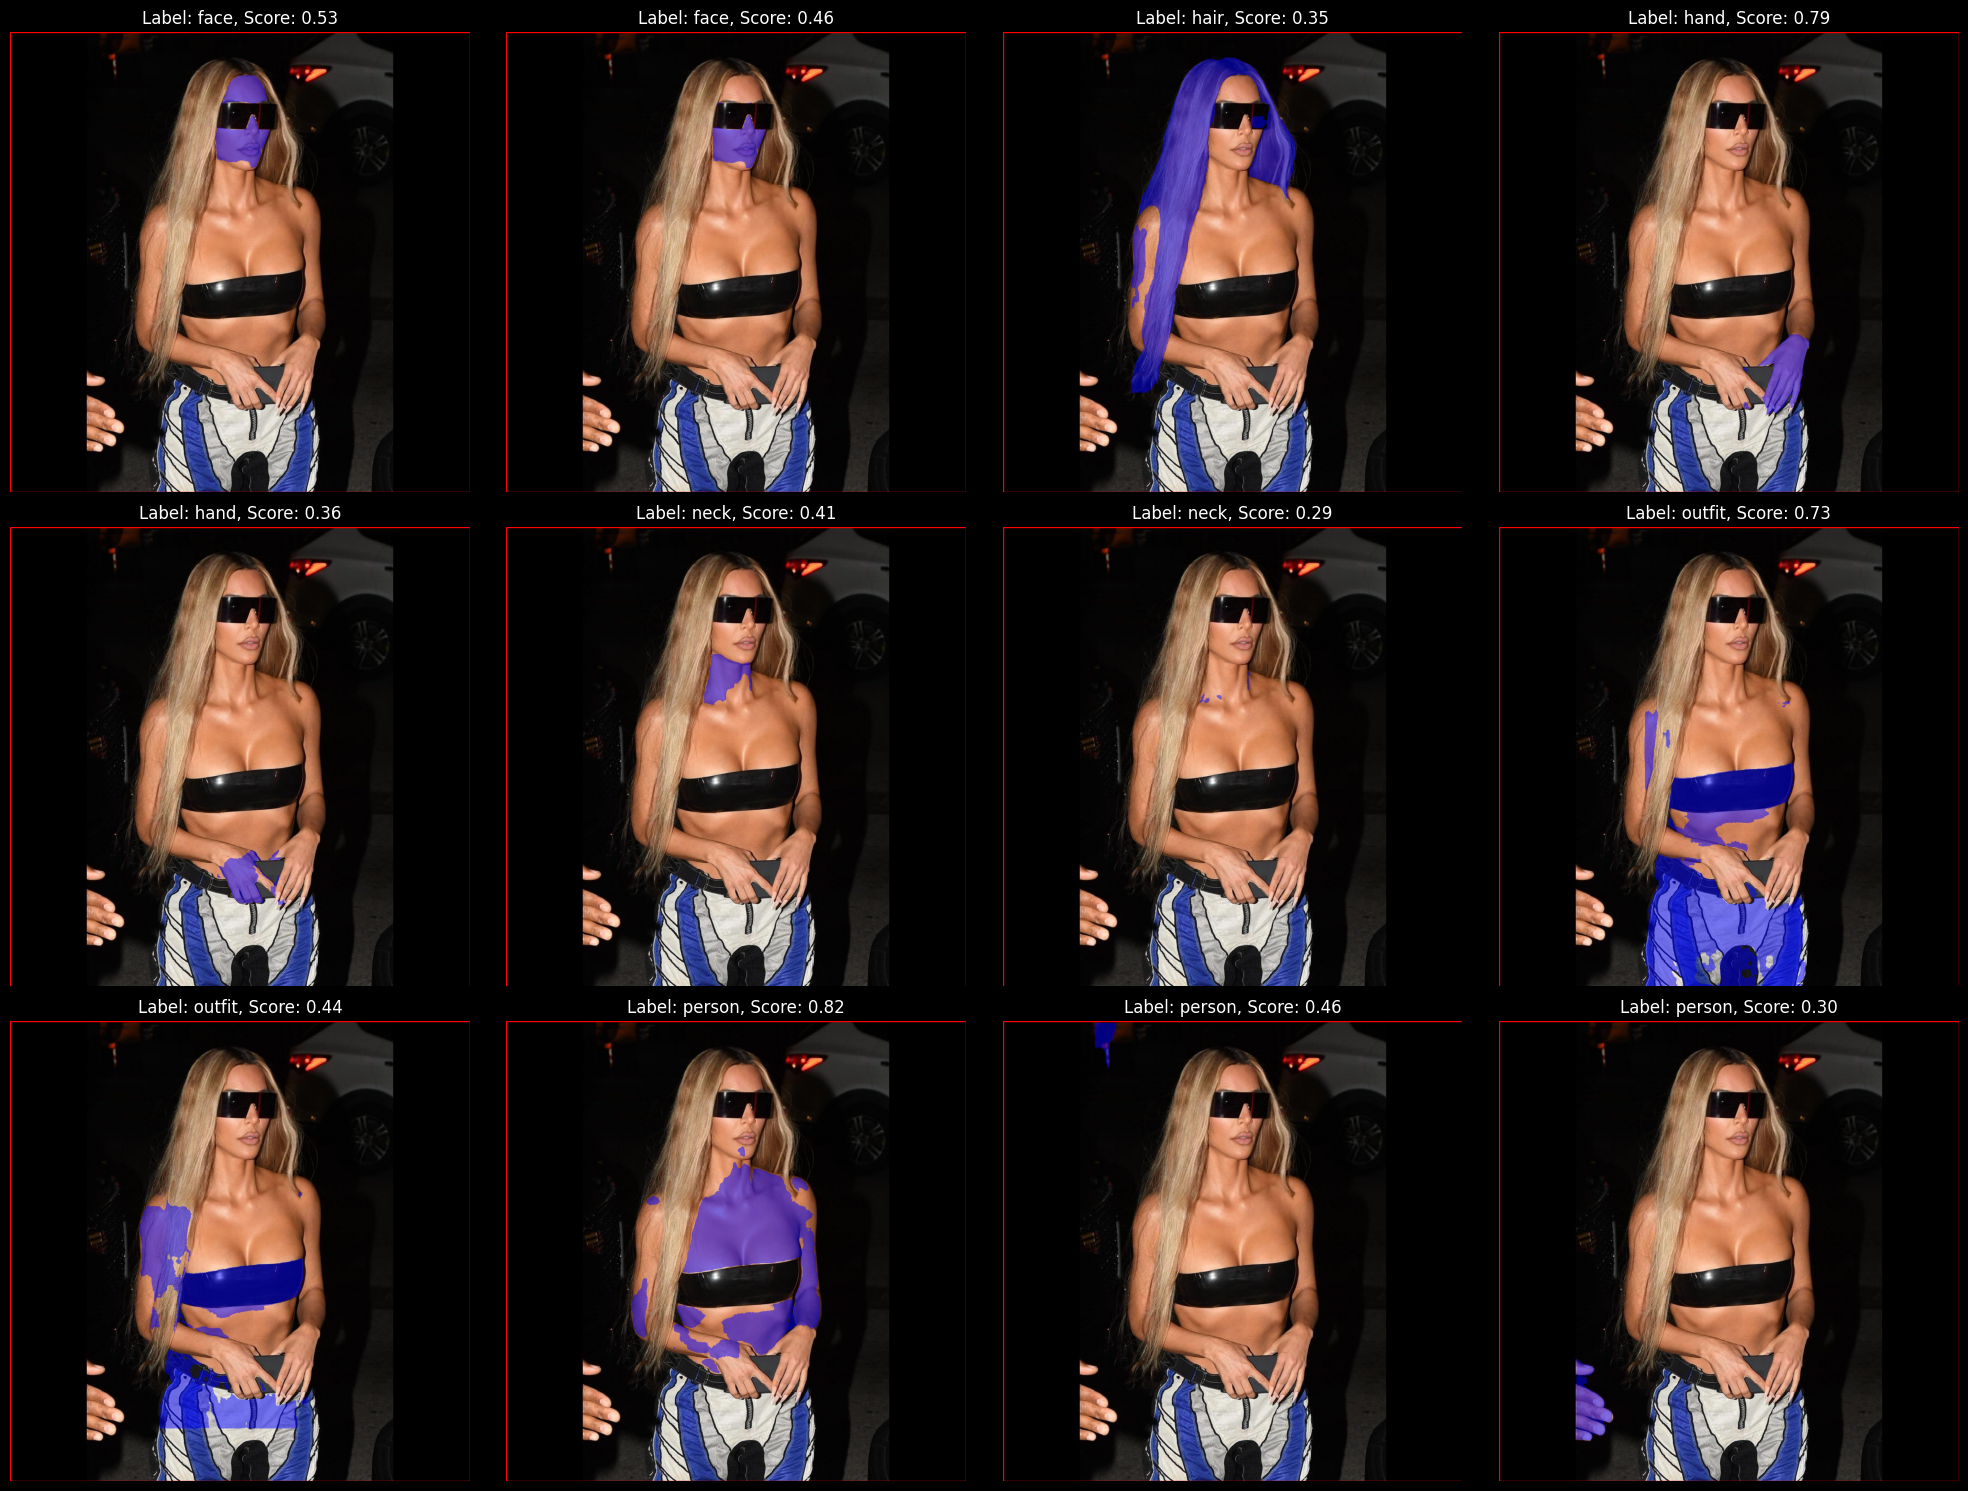

In [10]:
r.display_results()

In [11]:
r.formatted_results

[{'label': 'face',
  'score': 0.5281400680541992,
  'mask': <PIL.Image.Image image mode=L size=1024x1024>,
  'box': [455.4385986328125,
   62.843505859375,
   581.287841796875,
   316.1486511230469],
  'label_id': 1},
 {'label': 'face',
  'score': 0.4593186378479004,
  'mask': <PIL.Image.Image image mode=L size=1024x1024>,
  'box': [456.3582763671875,
   153.60873413085938,
   577.2891845703125,
   313.95849609375],
  'label_id': 1},
 {'label': 'hair',
  'score': 0.3478001356124878,
  'mask': <PIL.Image.Image image mode=L size=1024x1024>,
  'box': [283.10455322265625,
   39.963134765625,
   682.615966796875,
   800.243408203125],
  'label_id': 0},
 {'label': 'hand',
  'score': 0.789495587348938,
  'mask': <PIL.Image.Image image mode=L size=1024x1024>,
  'box': [540.655029296875, 670.94384765625, 689.228271484375, 851.759765625],
  'label_id': 4},
 {'label': 'hand',
  'score': 0.36439844965934753,
  'mask': <PIL.Image.Image image mode=L size=1024x1024>,
  'box': [456.9814453125,
   708.